In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from scipy.optimize import minimize

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
!pip install pyscf

In [3]:
from qiskit.circuit import ClassicalRegister, QuantumCircuit, QuantumRegister


def encode_data(num_qubits: int, bond_length: float) -> QuantumCircuit:
    """Encodes the data points in a quantum state.

    Args:
        num_qubits (int): The number of qubits.
        bond_length (float): Bond length.

    Returns:
        QuantumCircuit: The quantum state that represents the encoded data.
    """
    qubits = QuantumRegister(size = num_qubits, name = "qubits")
    bits = ClassicalRegister(size = num_qubits, name = "bits")
    
    qc = QuantumCircuit(qubits, bits)
    
    qc.h(qubit = qubits)
    qc.ry(theta = bond_length, qubit = qubits)
    
    return qc

In [4]:
from qiskit.circuit import QuantumCircuit, ParameterVector


def apply_ansatz(qc: QuantumCircuit, params: ParameterVector, reps: int) -> None:
    """Applies a gate sequence that defines the ansatz.

    Args:
        qc (QuantumCircuit): The encoded quantum circuit.
        params (ParameterVector): Parameters that will be optimized.
        reps (int): The number of repetitions.
    """
    for i in range(reps):
        
        qc.cx(control_qubit = qc.qregs[0][0], target_qubit = qc.qregs[0][1])
        qc.ry(theta = params[4*i], qubit = qc.qregs[0][0])
        qc.ry(theta = params[4*i+1], qubit = qc.qregs[0][1])
        qc.cx(control_qubit = qc.qregs[0][1], target_qubit = qc.qregs[0][0])
        qc.ry(theta = params[4*i+2], qubit = qc.qregs[0][0])
        qc.ry(theta = params[4*i+3], qubit = qc.qregs[0][1])
        qc.barrier()

In [5]:
from qiskit.providers.aer import QasmSimulator


def neural_net(num_qubits: int, bond_length: float, parameters: ParameterVector, backend: QasmSimulator) -> QuantumCircuit:
    """Creates the neural network.

    Args:
        num_qubits (int): The number of qubits.
        bond_length (float): Bond length.
        backend (QasmSimulator): The qasm simulator.

    Returns:
        QuantumCircuit: The quantum circuit that represents the neural network.
    """
    
    qubits = QuantumRegister(size = num_qubits)
    bits = ClassicalRegister(size = num_qubits)
    
    qc = QuantumCircuit(qubits, bits)
    
    if len(parameters)%8 != 0:
        
        raise ValueError("Number of parameters should be multiples of 8!")
    
    params_per_layer = int(len(parameters)/2)
    params1 = ParameterVector(r"\theta_1", length = params_per_layer)
    params2 = ParameterVector(r"\theta_2", length = params_per_layer)
    
    qc_enc = encode_data(num_qubits = num_qubits, bond_length = bond_length)
    qc = qc.compose(other = qc_enc)
    
    reps_ansatz = int(len(params1)/4)
    apply_ansatz(qc = qc, params = params1, reps = reps_ansatz)
    
    qc.measure(qubit = qubits, cbit = bits)
    
    qc = qc.bind_parameters({params1:parameters[:params_per_layer]})
    
    job = backend.run(qc)
    result = job.result()
    
    count_dict = result.data()['counts']
    total_count = sum(count_dict.values())
    c_0 = 0
    c_2 = 0
    c_4 = 0
    c_6 = 0
    
    if '0x0' in count_dict.keys():
        
        c_0 = count_dict['0x0']
    if '0x2' in count_dict.keys():
        
        c_2 = count_dict['0x2']
    if '0x4' in count_dict.keys():
        
        c_4 = count_dict['0x4']
    if '0x6' in count_dict.keys():
        
        c_6 = count_dict['0x6']
        
    m_0_p_0 = (c_0 + c_4)/total_count
    m_0_p_1 = (c_2 + c_6)/total_count
    m_1_p_0 = (c_0 + c_2)/total_count
    m_1_p_1 = (c_4 + c_6)/total_count
    
    qc.reset(qubit = qubits)
    qc.h(qubit = qubits)
    qc.ry(theta = np.pi*(m_0_p_0 - m_0_p_1), qubit = qubits[0])
    qc.ry(theta = np.pi*(m_1_p_0 - m_1_p_1), qubit = qubits[1])
    
    apply_ansatz(qc = qc, params = params2, reps = reps_ansatz)
    qc = qc.bind_parameters({params2: parameters[params_per_layer:]})
    
    return qc


def neural_net_without_meas(num_qubits: int, bond_length: float, parameters: ParameterVector) -> QuantumCircuit:
    """Creates the neural network.

    Args:
        num_qubits (int): The number of qubits.
        bond_length (float): Bond length.

    Returns:
        QuantumCircuit: The quantum circuit that represents the neural network.
    """
    
    qubits = QuantumRegister(size = num_qubits)
    bits = ClassicalRegister(size = num_qubits)
    
    qc = QuantumCircuit(qubits, bits)
    
    if len(parameters)%8 != 0:
        
        raise ValueError("Number of parameters should be multiples of 8!")
    
    params_per_layer = int(len(parameters)/2)
    params1 = ParameterVector(r"\theta_1", length = params_per_layer)
    params2 = ParameterVector(r"\theta_2", length = params_per_layer)
    
    qc_enc = encode_data(num_qubits = num_qubits, bond_length = bond_length)
    qc = qc.compose(other = qc_enc)
    
    reps_ansatz = int(len(params1)/4)
    apply_ansatz(qc = qc, params = params1, reps = reps_ansatz)
    qc = qc.bind_parameters({params1:parameters[:params_per_layer]})
    
    apply_ansatz(qc = qc, params = params2, reps = reps_ansatz)
    qc = qc.bind_parameters({params2: parameters[params_per_layer:]})
    
    return qc

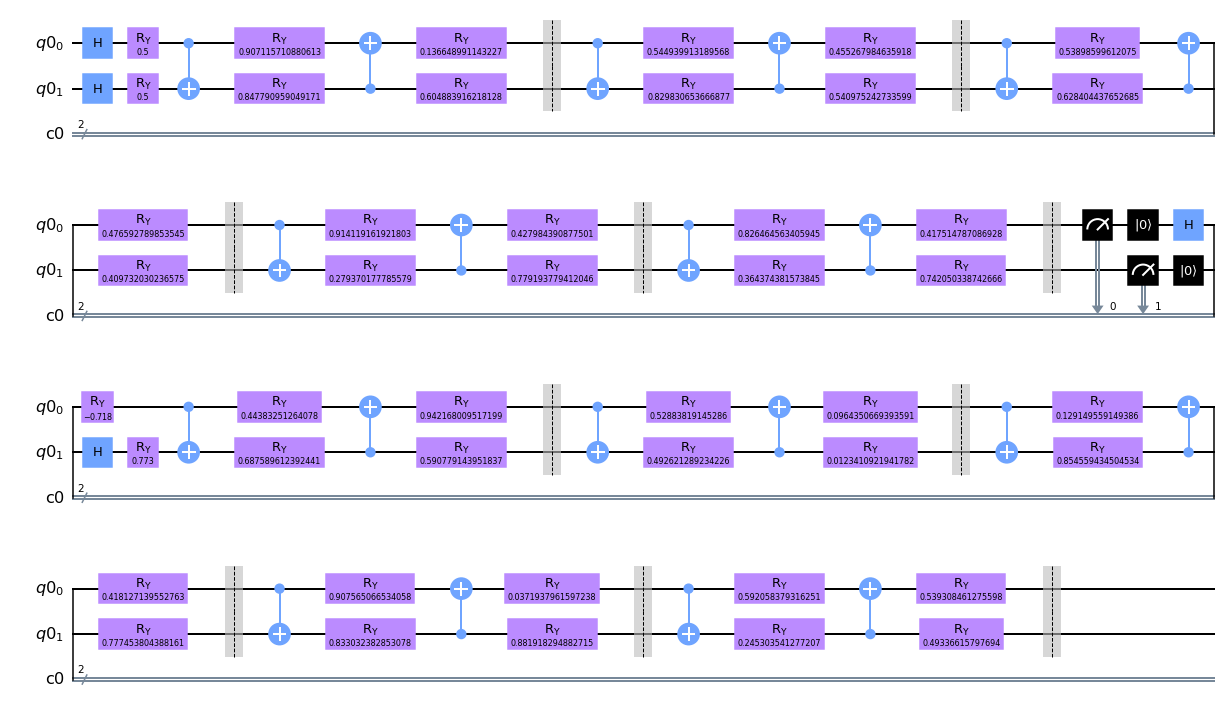

In [6]:
neural_net(2, 0.5, np.random.random(40), Aer.get_backend("qasm_simulator")).draw(output = "mpl")

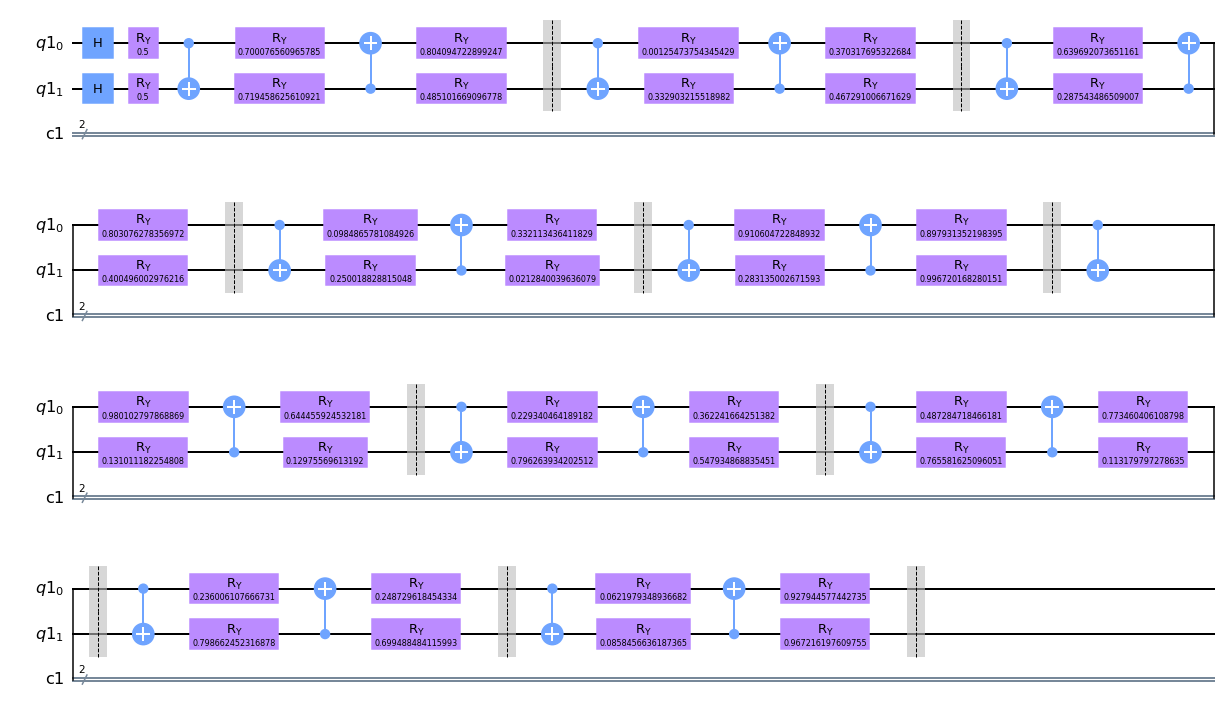

In [7]:
neural_net_without_meas(2, 0.5, np.random.random(40)).draw(output = "mpl")

In [8]:
from qiskit import Aer, execute
from qiskit_nature.algorithms import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.results.eigenstate_result import EigenstateResult


def exact_diagonalizer(problem: ElectronicStructureProblem, converter: QubitConverter) -> EigenstateResult:
    """Peforms an exact diagonalization in the Hamiltonian of the problem.

    Args:
        problem (ElectronicStructureProblem): Physical system of interest.
        converter (QubitConverter): A QubitConverter object.

    Returns:
        EigenstateResult: The result of the exact diagonalization.
    """
    
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver = solver)
    result = calc.solve(problem = problem)
    
    return result


def cost_function(hamiltonian, PQC):
    
    qc = PQC
    backend = Aer.get_backend("statevector_simulator")
    state = execute(experiments = qc, backend = backend).result().get_statevector()
    
    qubit_mat = hamiltonian.to_matrix()
    
    expectation_value = np.matmul(np.conjugate(state.T), np.matmul(qubit_mat, state))
    
    return expectation_value

In [9]:
from qiskit.opflow import PauliSumOp
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter


def hamiltonian_qubit_op(dist: float) -> PauliSumOp:
    """_summary_

    Args:
        dist (float): The distance between atoms.

    Returns:
        PauliSumOp: _description_
    """
    
    molecule = "H .0 .0 .0; H .0 .0 " + str(dist)
    driver = PySCFDriver(atom = molecule)
    qmolecule = driver.run()
    
    problem = ElectronicStructureProblem(driver = driver)
    
    second_q_ops = problem.second_q_ops()
    
    main_op = second_q_ops[0]
    mapper = ParityMapper()
    converter = QubitConverter(mapper = mapper, two_qubit_reduction = True)
    
    num_particles = problem.num_particles
    qubit_op = converter.convert(main_op, num_particles = num_particles)
    
    return qubit_op

In [10]:
dist = np.arange(0.5, 4, 0.1)
exact_energy_list = []
repulsion_energy_list = []
mapper = ParityMapper()

for i in range(len(dist)):
    
    molecule = "H .0 .0 .0; H .0 .0 " + str(dist[i])
    driver = PySCFDriver(atom = molecule)
    qmolecule = driver.run()
    
    problem = ElectronicStructureProblem(driver = driver)
    
    numpy_solver = NumPyEigensolverFactory(use_default_filter_criterion = True)
    converter = QubitConverter(mapper = mapper, two_qubit_reduction = True)
    numpy_excited_states_calculation = ExcitedStatesEigensolver(converter, numpy_solver)
    numpy_results = numpy_excited_states_calculation.solve(problem = problem)
    
    repulsion_energy = numpy_results.nuclear_repulsion_energy
    
    second_q_ops = problem.second_q_ops()
    
    main_op = second_q_ops[0]
    num_particles = problem.num_particles
    qubit_op = converter.convert(main_op, num_particles = num_particles)
    
    result_exact = exact_diagonalizer(problem = problem, converter = converter)
    exact_energy = np.real(result_exact.eigenenergies[0])
    exact_energy_list.append(exact_energy + repulsion_energy)
    repulsion_energy_list.append(repulsion_energy)
    print(f"Exact electronic energy: {exact_energy + repulsion_energy}")

Exact electronic energy: -1.0551597944706221
Exact electronic energy: -1.1162860068695375
Exact electronic energy: -1.1361894540659239
Exact electronic energy: -1.1341476666770944
Exact electronic energy: -1.1205602812999884
Exact electronic energy: -1.101150330232618
Exact electronic energy: -1.0791929449690754
Exact electronic energy: -1.0567407463052585
Exact electronic energy: -1.0351862664342557
Exact electronic energy: -1.015468249288246
Exact electronic energy: -0.9981493534714082
Exact electronic energy: -0.9834727290331728
Exact electronic energy: -0.971426688458342
Exact electronic energy: -0.9618169527925815
Exact electronic energy: -0.9543388539987281
Exact electronic energy: -0.9486411121761863
Exact electronic energy: -0.9443746811197434
Exact electronic energy: -0.9412240336932638
Exact electronic energy: -0.9389223859872751
Exact electronic energy: -0.9372549530096304
Exact electronic energy: -0.9360549199556073
Exact electronic energy: -0.9351960308474757
Exact electro

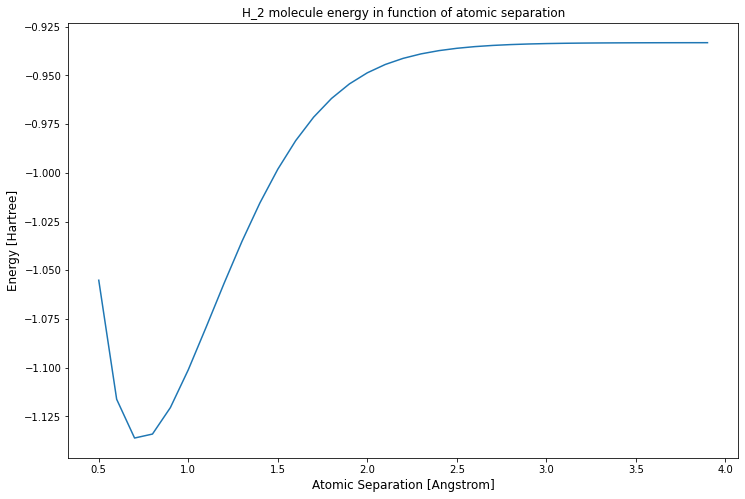

In [11]:
fig, ax = plt.subplots()
ax.plot(dist, exact_energy_list)
ax.set_ylabel("Energy [Hartree]", fontsize = 12)
ax.set_xlabel("Atomic Separation [Angstrom]", fontsize = 12)
ax.set_title("H_2 molecule energy in function of atomic separation", fontsize = 12)
fig.set_size_inches((12, 8))
plt.show()

In [12]:
fig.savefig("plot1.png")

In [13]:
dist = np.arange(0.5, 4, 0.1)
exact_energy = exact_energy_list

proportion = 0.5
training_index = np.random.randint(0, len(dist), size = int(np.ceil(len(exact_energy)*proportion)))
training_dist = np.zeros(len(training_index))
training_energy = np.zeros(len(training_index))

for j in range(len(training_index)):
    
    training_dist[j] = dist[training_index[j]]
    training_energy[j] = exact_energy[training_index[j]]
    
testing_index = np.arange(0, len(dist))
delete_index = []

for k in range(len(testing_index)):
    for l in range(len(training_dist)):
        if testing_index[k] == training_index[l]:
            
            delete_index.append(k)
            

testing_index = np.delete(testing_index, delete_index)
testing_dist = np.zeros(len(testing_index))
testing_energy = np.zeros(len(testing_index))

for m in range(len(testing_index)):
    
    testing_dist[m] = dist[testing_index[m]]
    testing_energy[m] = exact_energy[testing_index[m]]

In [14]:
def train_function(parameters):
    
    bond_length = training_dist
    energy = np.zeros(len(bond_length))
    for i in range(len(bond_length)):
        
        qc = neural_net(num_qubits = 2, bond_length = bond_length[i], parameters = parameters, backend = Aer.get_backend("qasm_simulator"))
        qubit_op = hamiltonian_qubit_op(dist = bond_length[i])
        energy[i] = cost_function(qubit_op, qc) + repulsion_energy_list[training_index[i]]
    energy_net = sum(energy)/len(bond_length)
    
    return energy_net

In [ ]:
out = minimize(train_function, x0 = np.random.random(40), method = "COBYLA", options = {'maxiter': 2000}, tol = 1e-4)

/tmp/ipykernel_381/564749647.py:35: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  expectation_value = np.matmul(np.conjugate(state.T), np.matmul(qubit_mat, state))
/tmp/ipykernel_381/26511219.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  energy[i] = cost_function(qubit_op, qc) + repulsion_energy_list[training_index[i]]


In [ ]:
parameters = out.x

energy = np.zeros(len(training_dist))

for n in range(len(training_dist)):
    
    bond_length = training_dist
    qc = neural_net(2, bond_length[n], parameters, backend = Aer.get_backend("qasm_simulator"))
    qubit_op = hamiltonian_qubit_op(bond_length[n])
    energy[n] = cost_function(qubit_op, qc) + repulsion_energy_list[training_index[n]]
    
energy_test = np.zeros(len(testing_dist))

for n in range(len(testing_dist)):
    
    bond_length_test = testing_dist
    qc = neural_net(2, bond_length_test[n], parameters, backend = Aer.get_backend("qasm_simulator"))
    qubit_op_test = hamiltonian_qubit_op(bond_length_test[n])
    energy_test[n] = cost_function(qubit_op_test, qc) + repulsion_energy_list[testing_index[n]]

In [ ]:
fig, ax = plt.subplots()
ax.plot(testing_dist, energy_test, marker = '*', label = "Testing Data")
ax.plot(training_dist, energy, marker = 'o', label = "Training Data")
ax.plot(dist, exact_energy_list, label = "Exact Energy")
ax.set_ylabel("Energy [Hartree]", fontsize = 12)
ax.set_xlabel("Atomic Separation [Angstrom]", fontsize = 12)
ax.set_title("H_2 molecule energy in function of atomic separation", fontsize = 12)
ax.set_legend()
fig.set_size_inches((12, 8))
plt.show()

In [ ]:
fig.savefig("plot2.png")

In [ ]:
def train_function_without_meas(parameters):
    
    bond_length = training_dist
    energy = np.zeros(len(bond_length))
    for i in range(len(bond_length)):
        
        qc = neural_net_without_meas(num_qubits = 2, bond_length = bond_length[i], parameters = parameters, backend = Aer.get_backend("qasm_simulator"))
        qubit_op = hamiltonian_qubit_op(dist = bond_length[i])
        energy[i] = cost_function(qubit_op, qc) + repulsion_energy_list[training_index[i]]
    energy_net = sum(energy)/len(bond_length)
    
    return energy_net

In [ ]:
out = minimize(train_function_without_neas, x0 = np.random.random(40), method = "COBYLA", options = {"maxiter": 2000})

In [ ]:
parameters = out.x

energy = np.zeros(len(training_dist))

for n in range(len(training_dist)):
    
    bond_length = training_dist
    qc = neural_net(2, bond_length[n], parameters, backend = Aer.get_backend("qasm_simulator"))
    qubit_op = hamiltonian_qubit_op(bond_length[n])
    energy[n] = cost_function(qubit_op, qc) + repulsion_energy_list[training_index[n]]
    
energy_test = np.zeros(len(testing_dist))

for n in range(len(testing_dist)):
    
    bond_length_test = testing_dist
    qc = neural_net(2, bond_length_test[n], parameters, backend = Aer.get_backend("qasm_simulator"))
    qubit_op_test = hamiltonian_qubit_op(bond_length_test[n])
    energy_test[n] = cost_function(qubit_op_test, qc) + repulsion_energy_list[testing_index[n]]

In [ ]:
fig, ax = plt.subplots()
ax.plot(testing_dist, energy_test, marker = '*', label = "Testing Data")
ax.plot(training_dist, energy, marker = 'o', label = "Training Data")
ax.plot(dist, exact_energy_list, label = "Exact Energy")
ax.set_ylabel("Energy [Hartree]", fontsize = 12)
ax.set_xlabel("Atomic Separation [Angstrom]", fontsize = 12)
ax.set_title("H_2 molecule energy in function of atomic separation", fontsize = 12)
ax.set_legend()
fig.set_size_inches((12, 8))
plt.show()

In [ ]:
fig.savefig("plot3.png")